# Editing a scene

## Overview

In this tutorial, you will learn how to modify a Mitsuba scene after it has been loaded from a file. You might want to edit a scene before (re-)rendering it for many reasons. Maybe a corner is dim, or an object should be moved a bit to the left. Thankfully we can use the *traverse* mechanism to perform such modifications in Python with Mitsuba 3. As we will see in later tutorials, this mechanism is also essential for inverse rendering applications and more.

<div class="admonition important alert alert-block alert-success">

🚀 **You will learn how to:**

<ul>
  <li>List exposed parameters of Mitsuba objects</li>
  <li>Edit a scene and update its internal state accordingly</li>
</ul>

</div>

## Loading a scene

Following the same steps as in [Mitsuba quickstart tutorial][1], let's import `mitsuba`, set the desired variant and load a scene from an XML file on disk.

[1]: https://mitsuba.readthedocs.io/en/latest/src/quickstart/mitsuba_quickstart.html

In [2]:
import drjit as dr
import mitsuba as mi
mi.set_variant('llvm_ad_spectral')

scene = mi.load_file("../scenes/bunny_and_dragon.xml")

Let's quickly render this scene.

TypeError: Invalid shape (256, 256, 6) for image data

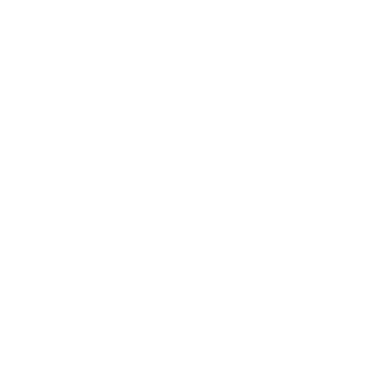

In [3]:
original_image = mi.render(scene, spp=128)

import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(original_image ** (1.0 / 2.2));

## Accessing scene parameters

Any Mitsuba object can be inspected using the [<code>traverse()</code>][1] function, which returns a instance of [<code>SceneParameters</code>][2]. It has a similar API to Python `dict` and holds all parameters that are exposed by the input object and its children. Therefore, when given a scene as input, this function will return the parameters of all the objects present in the scene.

Let's print the paramters available in our teapot scene.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.SceneParameters

In [4]:
params = mi.traverse(scene)
print(params)

SceneParameters[
  ----------------------------------------------------------------------------------------------------
  Name                                             Flags    Type           Parent
  ----------------------------------------------------------------------------------------------------
  sensor.near_clip                                          float          PerspectiveCamera
  sensor.far_clip                                           float          PerspectiveCamera
  sensor.shutter_open                                       float          PerspectiveCamera
  sensor.shutter_open_time                                  float          PerspectiveCamera
  sensor.film.size                                          ScalarVector2u HDRFilm
  sensor.film.crop_size                                     ScalarVector2u HDRFilm
  sensor.film.crop_offset                                   ScalarPoint2u  HDRFilm
  sensor.x_fov                                     ∂, D     Float         

## AOVs
 Mistuba offers tutorials related to [<code>Arbitrary Output Variables integrator</code>][1].

[1]: https://mitsuba.readthedocs.io/en/stable/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

In [ ]:
import numpy as np

def extract_and_save_channels(bitmap, channel_names, output_filename):
    """Extract specific channels from the bitmap and save them as one EXR file."""
    indices = [bitmap.channel_index(name) for name in channel_names]
    channels = bitmap.split()
    selected = [channels[i] for i in indices]
    merged = mi.Bitmap.merge(selected)
    merged.write(output_filename)

def save_all_aovs(bitmap):
    """Save spectral albedo, RGB albedo, shading normal, depth, and position as separate EXR files."""
    channels = bitmap.channel_names()

    # --- Save spectral albedo ---
    albedo_spectral_indices = [i for i, name in enumerate(channels) if name.startswith("albedo.")]
    if albedo_spectral_indices:
        albedo_spectral = mi.Bitmap.merge([bitmap.split()[i] for i in albedo_spectral_indices])
        albedo_spectral.write("albedo_spectral.exr")

        # Convert spectral albedo to RGB and save
        albedo_rgb = mi.util.spectrum_to_rgb(albedo_spectral)
        albedo_rgb.write("albedo_rgb.exr")

    # --- Save shading normal ---
    sh_normal_channels = ["sh_normal.X", "sh_normal.Y", "sh_normal.Z"]
    if all(c in channels for c in sh_normal_channels):
        extract_and_save_channels(bitmap, sh_normal_channels, "sh_normal.exr")

    # --- Save depth ---
    depth_channels = [c for c in channels if c.startswith("depth")]
    if depth_channels:
        extract_and_save_channels(bitmap, [depth_channels[0]], "depth.exr")

    # --- Save position ---
    position_channels = ["position.X", "position.Y", "position.Z"]
    if all(c in channels for c in position_channels):
        extract_and_save_channels(bitmap, position_channels, "position.exr")

def visualize_aovs(bitmap):
    """Visualize RGB image, shading normals, depth, and position from the bitmap using matplotlib."""
    channels = bitmap.channel_names()

    def get_channels_by_prefix(prefix):
        selected = [(i, name) for i, name in enumerate(channels) if name.startswith(prefix)]
        if not selected:
            return None
        indices, _ = zip(*selected)
        imgs = [np.array(bitmap.split()[i]) for i in indices]
        return np.stack(imgs, axis=-1)

    # Try to get RGB image (either 'image.*' or fallback to 'R', 'G', 'B')
    img = get_channels_by_prefix('image')
    if img is None:
        try:
            r = np.array(bitmap.split()[channels.index('R')])
            g = np.array(bitmap.split()[channels.index('G')])
            b = np.array(bitmap.split()[channels.index('B')])
            img = np.stack([r, g, b], axis=-1)
        except ValueError:
            img = None

    # Get shading normals
    normals = get_channels_by_prefix('sh_normal')

    # Get depth (single channel)
    depth = get_channels_by_prefix('depth')
    if depth is not None and depth.shape[-1] > 1:
        depth = depth[..., 0]

    # Get position
    position = get_channels_by_prefix('position')

    fig, axs = plt.subplots(1, 4, figsize=(18, 5))

    # Image display with gamma correction
    if img is not None:
        img_disp = np.clip(img, 0, 1) ** (1/2.2)
        axs[0].imshow(img_disp)
        axs[0].set_title('Rendered Image')
    else:
        axs[0].text(0.5, 0.5, "Image not found", ha='center', va='center')
    axs[0].axis('off')

    # Normal display remapped from [-1,1] to [0,1]
    if normals is not None:
        normal_disp = (normals + 1) * 0.5
        normal_disp = np.clip(normal_disp, 0, 1)
        axs[1].imshow(normal_disp)
        axs[1].set_title('Shading Normal')
    else:
        axs[1].text(0.5, 0.5, "Normals not found", ha='center', va='center')
    axs[1].axis('off')

    # Depth display normalized min-max with magma colormap
    if depth is not None:
        dmin, dmax = depth.min(), depth.max()
        depth_disp = (depth - dmin) / (dmax - dmin + 1e-8)
        axs[2].imshow(depth_disp, cmap='magma')
        axs[2].set_title('Depth')
    else:
        axs[2].text(0.5, 0.5, "Depth not found", ha='center', va='center')
    axs[2].axis('off')

    # Position display normalized min-max
    if position is not None:
        pmin, pmax = position.min(), position.max()
        pos_disp = (position - pmin) / (pmax - pmin + 1e-8)
        axs[3].imshow(pos_disp)
        axs[3].set_title('Position')
    else:
        axs[3].text(0.5, 0.5, "Position not found", ha='center', va='center')
    axs[3].axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
film = scene.sensors()[0].film()
bitmap = film.develop()
bitmap = bitmap.convert(
    pixel_format=mi.Bitmap.PixelFormat.MultiChannel,
    component_type=mi.Bitmap.ComponentType.Float32
)

save_all_aovs(bitmap)
visualize_aovs(bitmap)

## Edit the scene

Similarly to a Python `dict`, parameters can be modified in-place using the `__setitem__` operator. However, it is necessary to call the `SceneParameters.update` method to properly apply the desired changes.

Some objects need to be notified if the children have been updated. For instance, a change to the vertex position buffer of a mesh will trigger the recomputation of the Embree/Optix BHV.

Internally, the `SceneParameters` object will record every update written to it.
Using `SceneParameters.update` will propagate all updates through the dependency graph, and perform all necessary updates to the parent objects.

In [ ]:
# Give a red tint to light1 and a green tint to light2
params['light1.intensity.value'] *= [1.5, 0.2, 0.2]
params['light2.intensity.value'] *= [0.2, 1.5, 0.2]

# Apply updates
params.update();

Mesh editing is also possible but requires specifying the layout of the stored data. See [transformation toolbox][1] and [mesh manipulation][2] for more geometry and mesh operations.

[1]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/mesh_io_and_manipulation.html
[2]: https://mitsuba.readthedocs.io/en/latest/src/how_to_guides/image_io_and_manipulation.html

In [ ]:
# Translate the bunny a little bit
V = dr.unravel(mi.Point3f, params['bunny.vertex_positions'])
V.z += 0.5
params['bunny.vertex_positions'] = dr.ravel(V)

# Apply changes
params.update();

After rendering the scene again, we can easily compare the rendered images using `matplotlib`. 

In [ ]:
modified_image = mi.render(scene, spp=128)
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1,2,1).imshow(original_image); plt.axis('off'); plt.title('original')
fig.add_subplot(1,2,2).imshow(modified_image); plt.axis('off'); plt.title('modified');

## See also

- [<code>mitsuba.traverse()</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.traverse)
- [<code>mitsuba.SceneParameters</code>](https://mitsuba.readthedocs.io/en/latest/src/api_reference.html##mitsuba.SceneParameters)